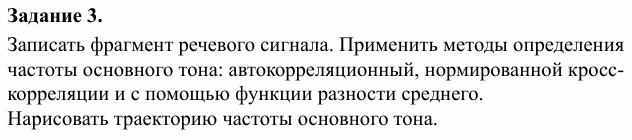

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal

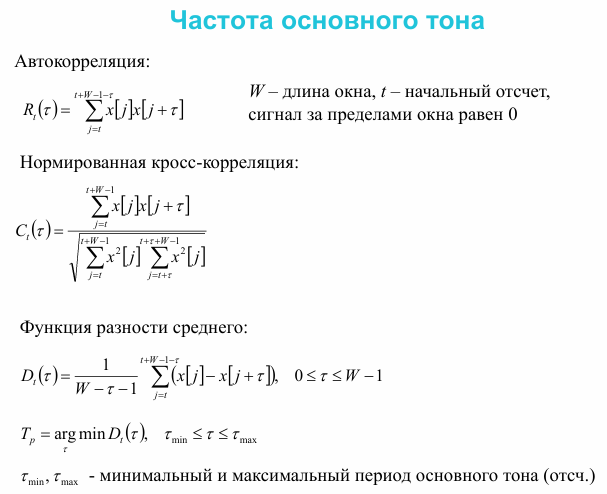

In [2]:
def autocorrelation(audio, tau_min, tau_max):
    W = len(audio)
    corr = np.zeros(tau_max + 1)

    for tau in range(tau_min, tau_max + 1):
        sum_corr = 0
        for j in range(W - tau):
            sum_corr += audio[j] * audio[j + tau]
        corr[tau] = sum_corr

    return corr

def normalized_cross_correlation(audio, tau_min, tau_max):
    W = len(audio)
    corr = np.zeros(tau_max + 1)

    for tau in range(tau_min, tau_max + 1):
        sum_corr = 0
        sum_x2 = 0
        sum_x2_tau = 0

        for j in range(W - tau):
            sum_corr += audio[j] * audio[j + tau]
            sum_x2 += audio[j] ** 2
            sum_x2_tau += audio[j + tau] ** 2

        if sum_x2 * sum_x2_tau > 0:
            corr[tau] = sum_corr / np.sqrt(sum_x2 * sum_x2_tau)
        else:
            corr[tau] = 0

    return corr

def average_difference_function(audio, tau_min, tau_max):
    W = len(audio)
    diff = np.zeros(tau_max + 1)

    for tau in range(tau_min, tau_max + 1):
        sum_diff = 0
        for j in range(W - tau):
            sum_diff += np.abs(audio[j] - audio[j + tau])
        diff[tau] = sum_diff / (W - tau - 1)

    return diff

def calculate_frequency_max(corr, tau_min, tau_max, fs):
    peak = np.argmax(corr[tau_min:tau_max + 1]) + tau_min
    return fs / peak

def calculate_frequency_min(corr, tau_min, tau_max, fs):
    peak = np.argmin(corr[tau_min:tau_max + 1]) + tau_min
    return fs / peak

def plot_trajectory(times, freqs, title, color, ax, loc, ylim, xlim):
    ax.plot(times, freqs, marker='.', linestyle='None', color=color, label=title)
    ax.legend(loc=loc)
    ax.set_ylabel('Частота (Гц)')
    ax.set_xlabel('Время (сек)')
    ax.grid()
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)

In [3]:
def plot_pitch_trajectories(filename):
    audio, fs = librosa.load(filename)

    # Параметры частот
    f_min, f_max = 70, 250
    t_min, t_max = int(fs / f_max), int(fs / f_min)

    # Параметры окна
    frame_length = int(fs * 0.025)  # 25 мс
    step = int(fs * 0.005)          # 5 мс

    autocorr_freqs, ncc_freqs, avg_diff_freqs = [], [], []
    times = []

    for i in range(0, len(audio) - frame_length, step):
        frame = audio[i:i + frame_length] * signal.get_window("hann", frame_length)

        autocorr = autocorrelation(frame, t_min, t_max)
        ncc = normalized_cross_correlation(frame, t_min, t_max)
        avg_diff = average_difference_function(frame, t_min, t_max)

        autocorr_freq = calculate_frequency_max(autocorr, t_min, t_max, fs)
        ncc_freq = calculate_frequency_max(ncc, t_min, t_max, fs)
        avg_diff_freq = calculate_frequency_min(avg_diff, t_min, t_max, fs)

        autocorr_freqs.append(autocorr_freq)
        ncc_freqs.append(ncc_freq)
        avg_diff_freqs.append(avg_diff_freq)

        times.append(i / fs)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, figsize=(7, 8))
    plt.suptitle('Траектория ЧОТ')

    ylim = (130, 260)
    xlim = (0, times[-1] if times else 1)

    plot_trajectory(times, autocorr_freqs, 'Автокорреляция', 'green', ax1, 'upper right', ylim, xlim)
    plot_trajectory(times, ncc_freqs, 'Нормированная кросс-корреляция', 'blue', ax2, 'upper right', ylim, xlim)
    plot_trajectory(times, avg_diff_freqs, 'Разность среднего', 'red', ax3, 'upper right', ylim, xlim)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

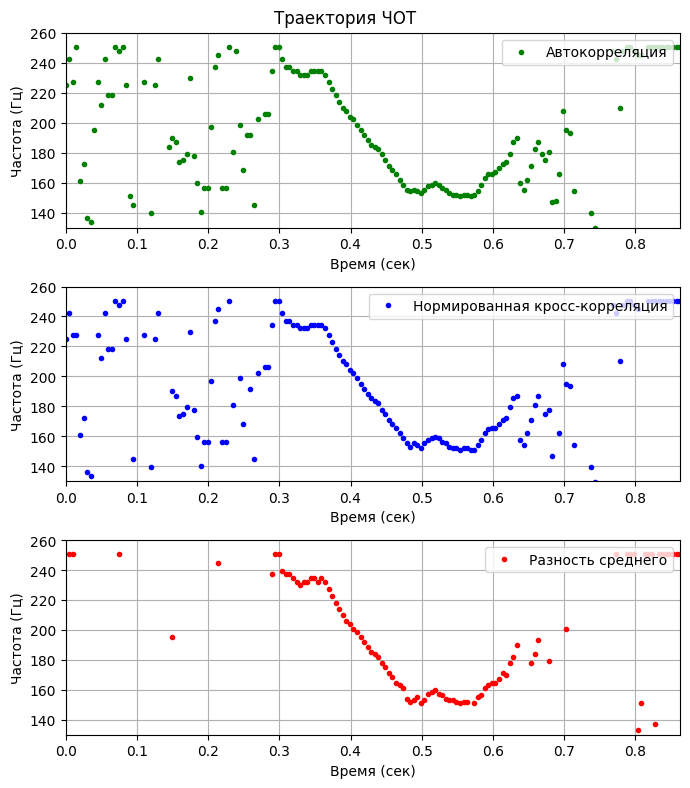

In [4]:
plot_pitch_trajectories('word.wav')

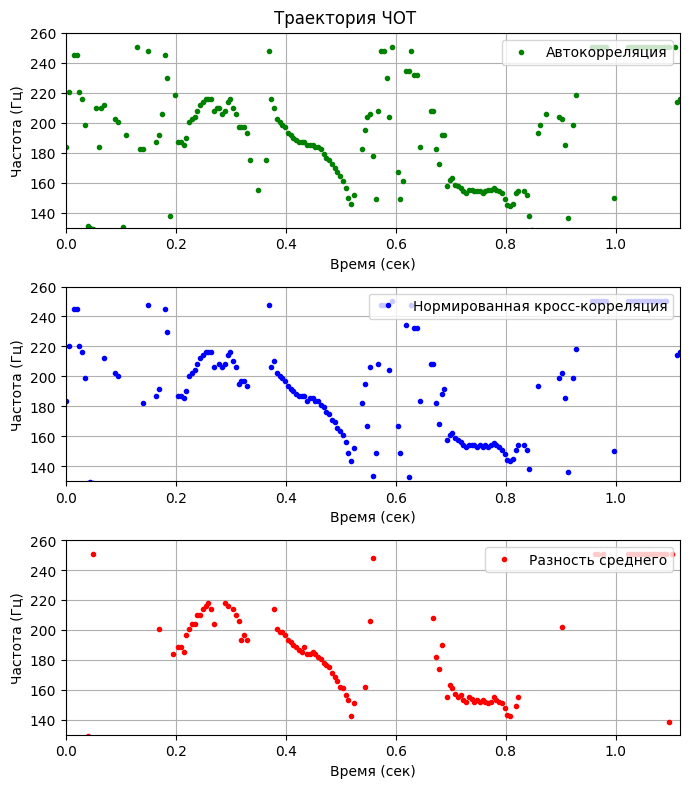

In [5]:
plot_pitch_trajectories('word_2_neutral.wav')

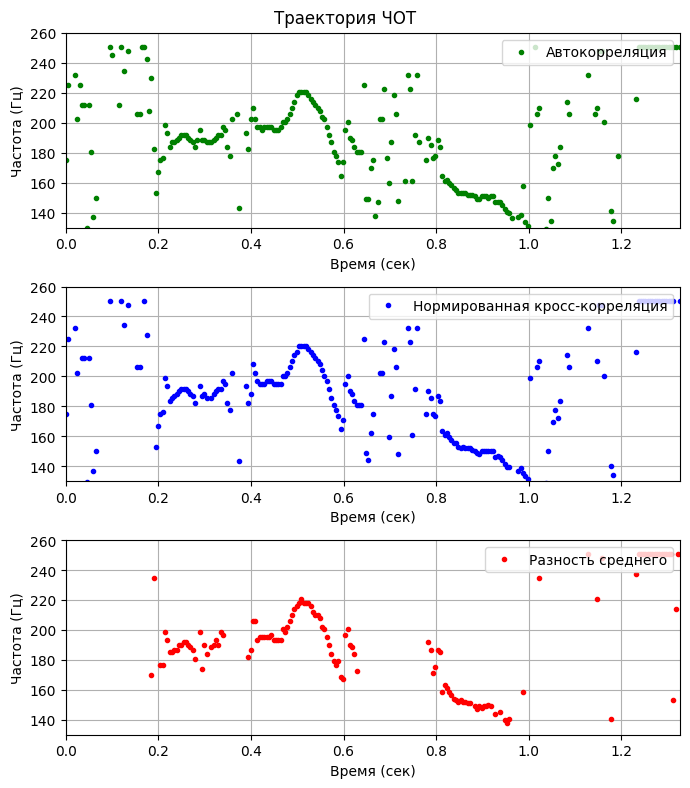

In [6]:
plot_pitch_trajectories('word_2_emotions.wav')